In [1]:
import os, cv2, time
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
def create_paths(dataset_dir):
    rgb_files = []
    mask_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for name in files:
            f = os.path.join(root, name)
            if 'labelIds' in f:
                mask_files.append(f)
            elif 'rgb_anon' in f:
                rgb_files.append(f)
            else:
                pass
    return sorted(rgb_files), sorted(mask_files)

In [3]:
class customDataset(Dataset):
    """ Custom Dataset for multiclass semantic segmentation.

    Args:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        class_list (list): List of class IDs to extract from segmentation mask.
        preprocessing (callable, optional): Data preprocessing function.
    """
    
    def __init__(self, df, class_list=None, augmentation=None, preprocessing=None):
        self.image_paths = df['rgb_file'].tolist()
        self.mask_paths = df['mask_file'].tolist()

        self.class_list = class_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # Original Cityscapes IDs to be mapped to your 6 classes
        # [7, 11, 21, 26, 23, 24] # ['road', 'building', 'vegetation', 'car', 'sky', 'person']
        self.cityscapes_ids = [7, 11, 21, 26, 23]  # Target classes
        # Mapping to new class indices [0, 1, 2, 3, 4, 5]
        self.new_class_mapping = {7: 1, 11: 2, 21: 3, 26: 4, 23: 5}   
        # Define a background class ID
        #self.background_class_id = -1  # Or any other value not used by your classes

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY)  # Read mask as grayscale

        # Resize images and masks (640, 480)/(1920, 1080)
        image = cv2.resize(image, (1920, 1056), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (1920, 1056), interpolation=cv2.INTER_NEAREST)

        image = np.asarray(image).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            image = self.preprocessing(image)
            image = torch.as_tensor(image)
        else:
            # Normalize image to [0, 1]
            image = torch.as_tensor(image) / 255.0
        image = image.permute(2,0,1)

        # Convert mask to tensor
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        
        # Map original Cityscapes IDs to the new class indices
        mask_mapped = np.zeros_like(mask, dtype=np.uint8)  # Initialize new mask
        for original_id, new_id in self.new_class_mapping.items():
            mask_mapped[mask == original_id] = new_id

        # Convert mask to tensor with the mapped classes
        mask_tensor = torch.as_tensor(mask_mapped, dtype=torch.long)

        # -------------------
        # Convert mask to tensor and remap class IDs
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        #mask_mapped = torch.full_like(mask, self.background_class_id, dtype=torch.long)  # Initialize new mask with background class ID
        
        #for original_id, new_id in self.new_class_mapping.items():
        #    mask_mapped[mask == original_id] = new_id

        return image.float(), mask_tensor

    def __len__(self):
        return len(self.image_paths)


In [4]:
# Function to save a tensor as an image (after converting to numpy)
def save_image(tensor, filename):
    #image = Image.fromarray(tensor)
    #image.save(filename)

    # Ensure the tensor is on the CPU
    #tensor = tensor.cpu()

    # Define the transform to convert tensor to a PIL Image
    to_pil = transforms.ToPILImage()

    # Convert tensor to PIL image and save
    pil_image = to_pil(tensor)
    pil_image.save(filename)



In [5]:
# Function to plot the images: original, ground truth, and prediction
def plot_results(output_folder, i, img, ground_truth, prediction_unet, prediction_fpn, prediction_pspnet, prediction_deeplab):

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the images to the specified folder
    #save_image(img, os.path.join(output_folder, 'img.png'))
    #save_image(ground_truth, os.path.join(output_folder, 'ground_truth.png'))
    #save_image(prediction_unet, os.path.join(output_folder, 'prediction_unet.png'))
    #save_image(prediction_fpn, os.path.join(output_folder, 'prediction_fpn.png'))
    #save_image(prediction_pspnet, os.path.join(output_folder, 'prediction_pspnet.png'))
    #save_image(prediction_deeplab, os.path.join(output_folder, 'prediction_deeplab.png'))

    # Save the images with the iteration index "i" in their filenames
    save_image(img, os.path.join(output_folder, f'img_{i}.png'))
    save_image(ground_truth, os.path.join(output_folder, f'ground_truth_{i}.png'))
    save_image(prediction_unet, os.path.join(output_folder, f'prediction_unet_{i}.png'))
    save_image(prediction_fpn, os.path.join(output_folder, f'prediction_fpn_{i}.png'))
    save_image(prediction_pspnet, os.path.join(output_folder, f'prediction_pspnet_{i}.png'))
    save_image(prediction_deeplab, os.path.join(output_folder, f'prediction_deeplab_{i}.png'))

    
    fig, axs = plt.subplots(1,  6, figsize=(15, 5))
    
    axs[0].imshow(img.permute(1, 2, 0))  # permute to HWC for plotting
    axs[0].set_title('Original Image')
    
    axs[1].imshow(ground_truth.squeeze())  # Ground truth mask
    axs[1].set_title('Ground Truth Mask')
    
    axs[2].imshow(prediction_unet.squeeze())  # Predicted mask
    axs[2].set_title('UNet Prediction')

    axs[3].imshow(prediction_fpn.squeeze())  # Predicted mask
    axs[3].set_title('FPN Prediction')

    axs[4].imshow(prediction_pspnet.squeeze())  # Predicted mask
    axs[4].set_title('PSPNet Prediction')

    axs[5].imshow(prediction_deeplab.squeeze())  # Predicted mask
    axs[5].set_title('DeepLabV3+ Prediction')
    
    plt.show()

In [6]:
# Function to convert class IDs (0 to 5) back to RGB values
def ids_to_color(mask_ids):
    # Define the RGB mapping for each class ID
    id_to_color_mapping = {
        0: (0, 0, 0),         # background
        1: (128, 64, 128),    # road
        2: (70, 70, 70),      # building
        3: (107, 142, 35),    # vegetation
        4: (0, 0, 142),       # car
        5: (70, 130, 180),    # sky
    }

    # Create an empty array for the color image
    height, width = mask_ids.shape
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Map class IDs to RGB values
    for id_value, color in id_to_color_mapping.items():
        mask = (mask_ids == id_value)
        color_image[mask] = color

    return color_image

In [7]:
def compare_methods(data, folder):    
    # Generate 6 random indexes to pick sample images from the dataset
    random_indexes = random.sample(range(len(data)), 6)

    # Loop over the random indexes
    for i in random_indexes:
        img_test, gt_mask = data[i]  # Get the test image and ground truth mask
        
        # Convert image to batch format and move to device
        img_test = img_test.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
        # Predict the mask
        with torch.no_grad():
        
            pred_unet = segmodel_unet(img_test)  # Predict the mask
            pred_mask_unet = torch.argmax(pred_unet, dim=1).cpu()  # Get the class with the highest score
            
            pred_fpn = segmodel_fpn(img_test)  # Predict the mask
            pred_mask_fpn = torch.argmax(pred_fpn, dim=1).cpu()  # Get the class with the highest score
    
            pred_pspnet = segmodel_pspnet(img_test)  # Predict the mask
            pred_mask_pspnet = torch.argmax(pred_pspnet, dim=1).cpu()  # Get the class with the highest score
    
            pred_deeplab = segmodel_deeplab(img_test)  # Predict the mask
            pred_mask_deeplab = torch.argmax(pred_deeplab, dim=1).cpu()  # Get the class with the highest score
    
        # Convert class IDs back to RGB
        gt_mask_rgb = ids_to_color(gt_mask)
    
        pred_mask_unet = pred_mask_unet.squeeze()
        pred_mask_unet_rgb = ids_to_color(pred_mask_unet)
    
        pred_mask_fpn = pred_mask_fpn.squeeze()
        pred_mask_fpn_rgb = ids_to_color(pred_mask_fpn)
    
        pred_mask_pspnet = pred_mask_pspnet.squeeze()
        pred_mask_pspnet_rgb = ids_to_color(pred_mask_pspnet)
    
        pred_mask_deeplab = pred_mask_deeplab.squeeze()
        pred_mask_deeplabrgb = ids_to_color(pred_mask_deeplab)

        output_folder = os.path.join(folder, f"output_{i}")
        
        # Plot the original image, ground truth mask, and predicted mask
        plot_results(output_folder, i, img_test.cpu().squeeze(), gt_mask_rgb, pred_mask_unet_rgb, pred_mask_fpn_rgb, pred_mask_pspnet_rgb, pred_mask_deeplabrgb)

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [9]:
# for real images dataset
dataset_real_dir = '/home/vhsillerico/Documents/datasets/acdc-night'
imgs_real_rgb, imgs_real_mask = create_paths(dataset_real_dir)
#print(f'LEN imgs_acdc_rgb: {len(imgs_acdc_rgb)} --- LEN imgs_acdc_mask: {len(imgs_acdc_mask)}')
df_real = pd.DataFrame({'rgb_file': imgs_real_rgb, 'mask_file': imgs_real_mask})
df_real.sort_values(by='rgb_file',inplace=True)
df_real.reset_index(drop=True, inplace=True)
df_real = df_real.sample(frac=1).reset_index(drop=True)
df_real.head(5)

,rgb_file,mask_file
0,/home/vhsillerico/Documents/datasets/acdc-nigh...,/home/vhsillerico/Documents/datasets/acdc-nigh...
1,/home/vhsillerico/Documents/datasets/acdc-nigh...,/home/vhsillerico/Documents/datasets/acdc-nigh...
2,/home/vhsillerico/Documents/datasets/acdc-nigh...,/home/vhsillerico/Documents/datasets/acdc-nigh...
3,/home/vhsillerico/Documents/datasets/acdc-nigh...,/home/vhsillerico/Documents/datasets/acdc-nigh...
4,/home/vhsillerico/Documents/datasets/acdc-nigh...,/home/vhsillerico/Documents/datasets/acdc-nigh...


In [10]:
# for synthetic images dataset
dataset_sim_dir = '/home/vhsillerico/Documents/datasets/carla-night'
imgs_sim_rgb, imgs_sim_mask = create_paths(dataset_sim_dir)
df_sim = pd.DataFrame({'rgb_file': imgs_sim_rgb, 'mask_file': imgs_sim_mask})
df_sim.sort_values(by='rgb_file',inplace=True)
df_sim.reset_index(drop=True, inplace=True)
df_sim = df_sim.sample(frac=1).reset_index(drop=True)
df_sim.head(5)

,rgb_file,mask_file
0,/home/vhsillerico/Documents/datasets/carla-nig...,/home/vhsillerico/Documents/datasets/carla-nig...
1,/home/vhsillerico/Documents/datasets/carla-nig...,/home/vhsillerico/Documents/datasets/carla-nig...
2,/home/vhsillerico/Documents/datasets/carla-nig...,/home/vhsillerico/Documents/datasets/carla-nig...
3,/home/vhsillerico/Documents/datasets/carla-nig...,/home/vhsillerico/Documents/datasets/carla-nig...
4,/home/vhsillerico/Documents/datasets/carla-nig...,/home/vhsillerico/Documents/datasets/carla-nig...


In [11]:
selected_class_list = [7, 11, 21, 26, 23]

In [12]:
# configure dataset for training
test_data = customDataset(df_real, class_list=selected_class_list)

In [13]:
# configure dataset for training
test_sim_data = customDataset(df_sim, class_list=selected_class_list)

In [14]:
num_classes = 6

In [15]:
segmodel_unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)

if os.path.exists('./best_model_unet_multiclass_merged30e/best_model_unet_multiclass_merged30e.pth'):
    segmodel_unet.load_state_dict(torch.load('./best_model_unet_multiclass_merged30e/best_model_unet_multiclass_merged30e.pth', map_location=device))
    segmodel_unet.to(device)
    segmodel_unet.eval()  # Set the model to evaluation mode
    print('Loaded UNet Multilabel model from this run.')
else:
    print("There is no saved model")

Loaded UNet Multilabel model from this run.


In [16]:
num_classes = 6
segmodel_fpn = smp.FPN(encoder_name='resnet34', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)

if os.path.exists('./best_model_FPN_multiclass_merged30e/best_model_FPN_multiclass_merged30e.pth'):
    segmodel_fpn.load_state_dict(torch.load('./best_model_FPN_multiclass_merged30e/best_model_FPN_multiclass_merged30e.pth', map_location=device))
    segmodel_fpn.to(device)
    segmodel_fpn.eval()  # Set the model to evaluation mode
    print('Loaded FPN Multilabel model from this run.')
else:
    print("There is no saved model")


Loaded FPN Multilabel model from this run.


In [17]:
segmodel_pspnet = smp.PSPNet(encoder_name='resnext50_32x4d', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)

if os.path.exists('./best_model_pspnet_multiclass_merged30e/best_model_pspnet_multiclass_merged30e.pth'):
    segmodel_pspnet.load_state_dict(torch.load('./best_model_pspnet_multiclass_merged30e/best_model_pspnet_multiclass_merged30e.pth', map_location=device))
    segmodel_pspnet.to(device)
    segmodel_pspnet.eval()  # Set the model to evaluation mode
    print('Loaded PSPNet Multilabel model from this run.')
else:
    print("There is no saved model")

Loaded PSPNet Multilabel model from this run.


In [18]:
segmodel_deeplab = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)

if os.path.exists('./best_model_deeplabv3_multiclass_merged30e/best_model_deeplabv3_multiclass_merged30e.pth'):
    segmodel_deeplab.load_state_dict(torch.load('./best_model_deeplabv3_multiclass_merged30e/best_model_deeplabv3_multiclass_merged30e.pth', map_location=device))
    segmodel_deeplab.to(device)
    segmodel_deeplab.eval()  # Set the model to evaluation mode
    print('Loaded DeepLabV3+ Multilabel model from this run.')
else:
    print("There is no saved model")

Loaded DeepLabV3+ Multilabel model from this run.


In [19]:
output_folder_real = 'real'

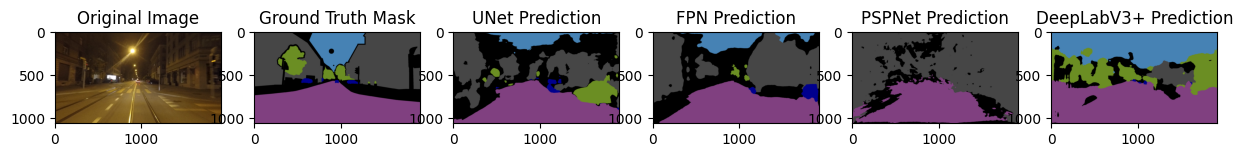

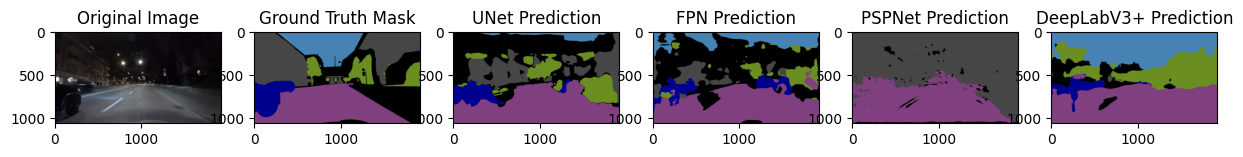

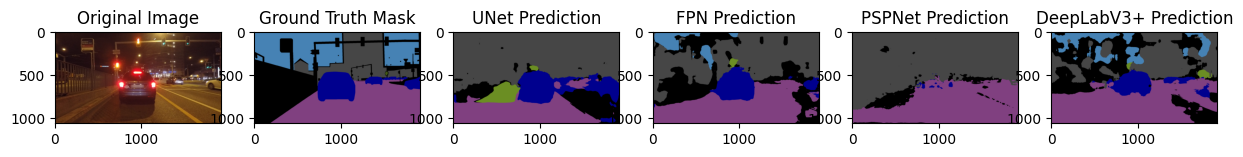

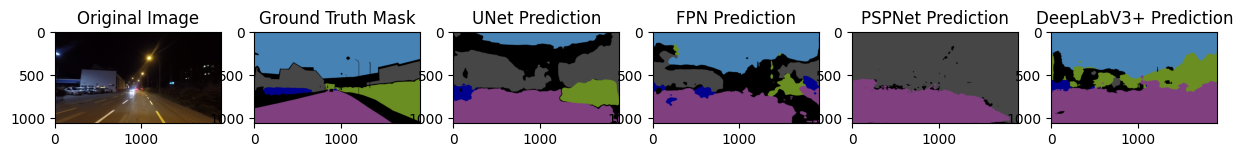

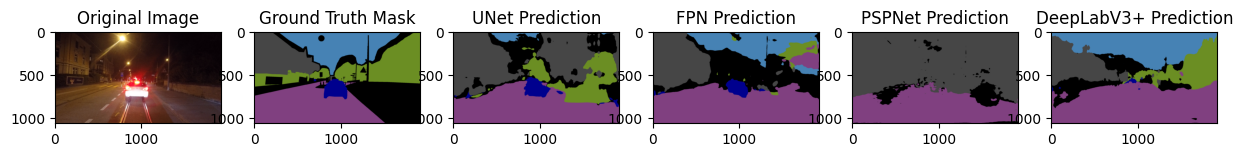

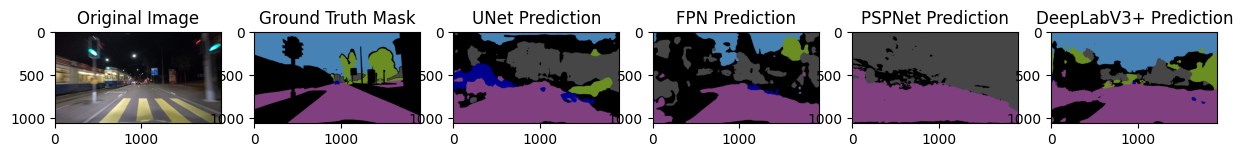

In [20]:
compare_methods(test_data, output_folder_real)

In [21]:
output_folder_sim = 'sim'

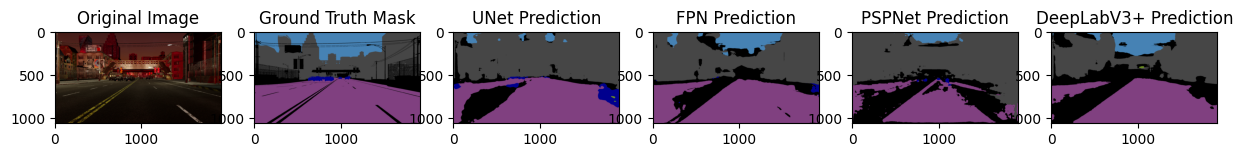

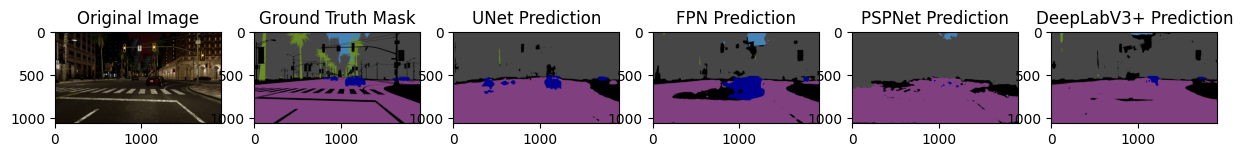

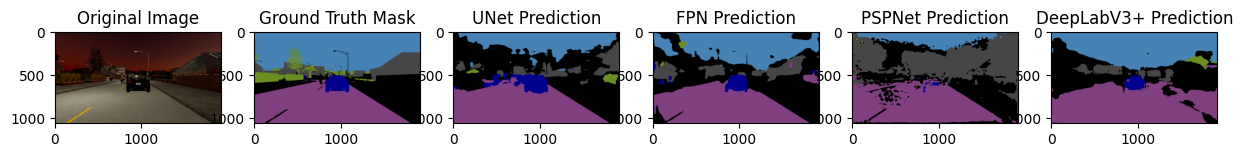

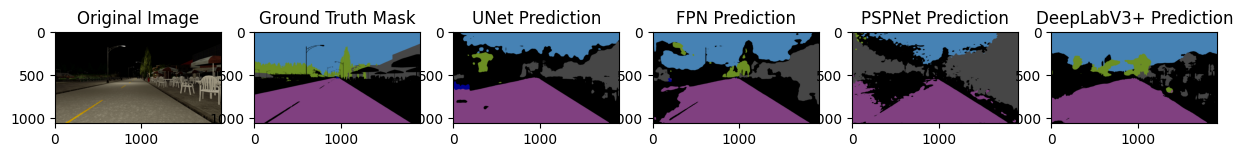

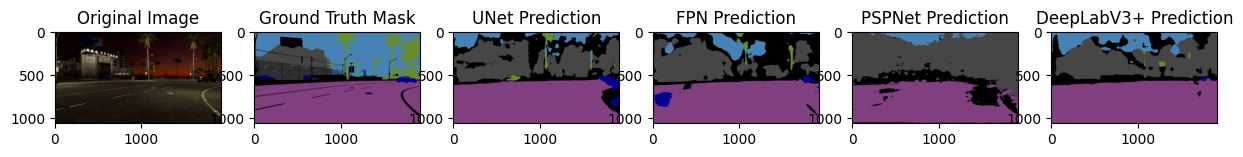

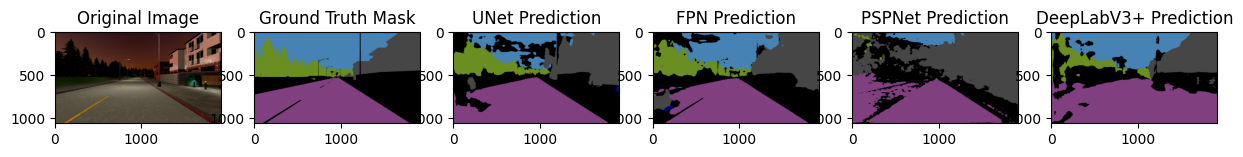

In [22]:
compare_methods(test_sim_data, output_folder_sim)